In [48]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
import time

# from model import Model
from dataset import WheatAwnDataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [66]:
def expose(model, epoch, dataloader, device, criterion, optimizer):
    print(f"EXPOSE  epoch: {epoch}")

    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    #set model mode
    model.eval()

    #make sure to not accumulate gradients
    with torch.no_grad():

        for images, labels in dataloader:

            #send the tensors to the device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            images = images.float()
            outputs = model(images) #float?

            #calculate the loss
            loss = criterion(outputs, labels)

            #add to the loss accumulated over the epoch
            epoch_loss += loss.item()

            #find the predicted classes indicies
            _, preds = torch.max(outputs, 1)

            #track the correct predictions (.item()to collect just the value)
            corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100

    print(f"---> loss: {epoch_loss} accuracy: {accuracy}")

    return epoch_loss, accuracy





def train(model, epoch, dataloader, device, criterion, optimizer):
    print(f"[train] epoch: {epoch}")

    #set model mode
    model.train()

    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    for images, labels in dataloader:

        images = images.float()

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        #calculate the loss
        loss = criterion(outputs, labels)

        #reset our gradients
        optimizer.zero_grad()

        #propagate backward
        loss.backward()

        #update weights
        optimizer.step()

        #add to the loss accumulated over the epoch
        epoch_loss += loss.item()

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100

    print(f"---> loss: {epoch_loss} accuracy: {accuracy}")

    return epoch_loss, accuracy

def validate(model, epoch, dataloader, device, criterion, optimizer):
    print(f"[validate]  epoch: {epoch}")

    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    #set model mode
    model.eval()

    #make sure to not accumulate gradients
    with torch.no_grad():

        for images, labels in dataloader:

            images = images.float()

            #send the tensors to the device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            #calculate the loss
            loss = criterion(outputs, labels)

            #add to the loss accumulated over the epoch
            epoch_loss += loss.item()

            #find the predicted classes indicies
            _, preds = torch.max(outputs, 1)

            #track the correct predictions
            corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100

    print(f"---> loss: {epoch_loss} accuracy: {accuracy}")

    return epoch_loss, accuracy

In [77]:
def main():

    print('running')

    #set the 'device' customary var for the GPU (or CPU if not available)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print("using device: ", device)


    #construct the datasets
    dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'

    #training data
    train_data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_tiny.csv'
#     train_transform = transforms.Compose([transforms.RandomRotation(0.2),
#                                       transforms.RandomCrop((224,224)), 
#                                       transforms.RandomHorizontalFlip(), 
#                                       transforms.RandomVerticalFlip()])
    train_transform = None
    training_data = WheatAwnDataset(csv_filepath=train_data_csv, dataset_dir=dataset_path, transform=train_transform)
    train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)

    #testing data
    validation_data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns_tiny.csv'
    validation_transform = None
    validation_data = WheatAwnDataset(csv_filepath=validation_data_csv, dataset_dir=dataset_path, transform=validation_transform)
    validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)

    #build the model
    model = Model().construct_model(verbose=False)

    model = model.to(device)

    #loss function
    criterion = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

    #set up lists to track training progress
    training_loss_history, training_accuracy_history = [],[]
    validation_loss_history, validation_accuracy_history = [], []

    #train the model across epochs
    epochs = 50

    for epoch in range(epochs):

        #make sure to expose the model first, with just the raw initilizations
        if epoch == 0:
            loss, accuracy = expose(model, epoch, train_dataloader, device, criterion, optimizer)
            print(type(loss))
            print(type(accuracy))
            training_loss_history.append(loss)
            training_accuracy_history.append(accuracy)

            loss, accuracy = expose(model, epoch, validation_dataloader, device, criterion, optimizer)
            validation_loss_history.append(loss)
            validation_accuracy_history.append(accuracy)

        #train
        loss, accuracy = train(model, epoch, train_dataloader, device, criterion, optimizer)
        training_loss_history.append(loss)
        training_accuracy_history.append(accuracy)

        #validate
        loss, accuracy = validate(model, epoch, validation_dataloader, device, criterion, optimizer)
        validation_loss_history.append(loss)
        validation_accuracy_history.append(accuracy)
    
    #save and plot
    current_time = time.strftime("%Y-%m-%d-%H_%M_%S")
    
    fig = plt.figure(figsize=(20,8))

    ax = fig.add_subplot(1, 2, 1)
    plt.plot(range(epochs+1), training_loss_history, label='train-loss')
    plt.plot(range(epochs+1), validation_loss_history, label= 'validation-loss')
    plt.ylabel('Training/Validation Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(epochs+1), training_accuracy_history, label='train-accuracy')
    plt.plot(range(epochs+1), validation_accuracy_history, label= 'validation-accuracy')
    plt.ylabel('Training/Validation accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')

    fig.savefig(f"/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/{current_time}_loss_accuracy-plot.jpg")

running
using device:  cuda:0
EXPOSE  epoch: 0
---> loss: 1.4334567165374756 accuracy: 48.5
<class 'float'>
<class 'float'>
EXPOSE  epoch: 0
---> loss: 1.7733187437057496 accuracy: 50.0
[train] epoch: 0
---> loss: 2.3571608889102937 accuracy: 58.5
[validate]  epoch: 0
---> loss: 0.07882328741252423 accuracy: 97.5
[train] epoch: 1
---> loss: 1.0177989745140075 accuracy: 72.5
[validate]  epoch: 1
---> loss: 0.04971862337552011 accuracy: 97.5
[train] epoch: 2
---> loss: 0.539837854206562 accuracy: 85.5
[validate]  epoch: 2
---> loss: 0.007688970352319302 accuracy: 100.0
[train] epoch: 3
---> loss: 0.4472348746843636 accuracy: 87.5
[validate]  epoch: 3
---> loss: 0.024186247677425853 accuracy: 97.5
[train] epoch: 4
---> loss: 0.2653596750937868 accuracy: 92.5
[validate]  epoch: 4
---> loss: 0.0011361601828411949 accuracy: 100.0
[train] epoch: 5
---> loss: 0.3030391220271122 accuracy: 92.0
[validate]  epoch: 5
---> loss: 0.00833048282895561 accuracy: 100.0
[train] epoch: 6
---> loss: 0.1517

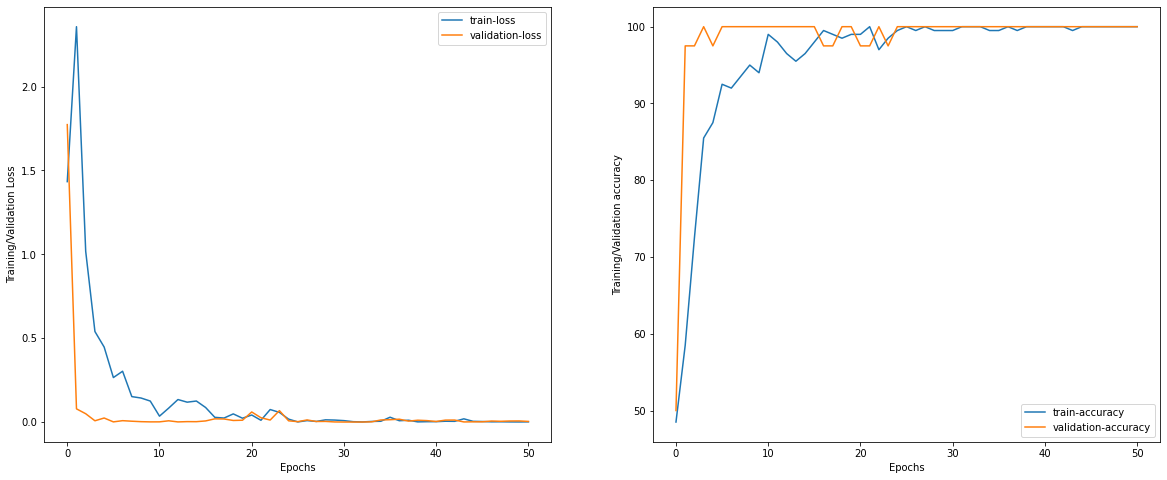

In [78]:
main()

In [ ]:
import os

search_dir = "/mydir/"
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files] # add path to each file
files.sort(key=lambda x: os.path.getmtime(x))

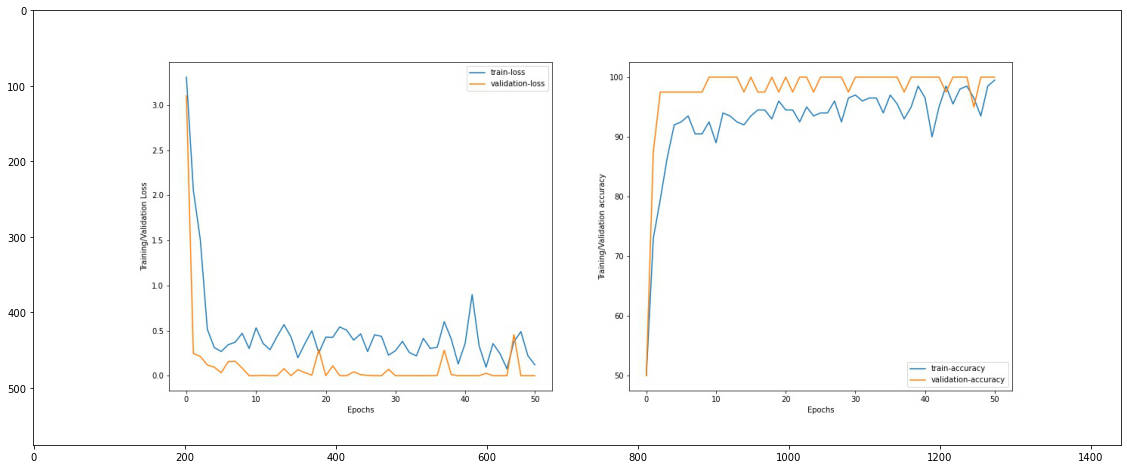

In [76]:
import PIL
pdir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
plots = os.listdir(pdir)
p = os.path.join(pdir, plots[2])
pimg = PIL.Image.open(p)
plt.figure(figsize = (20,8))
plt.imshow(pimg)


In [ ]:
plt.imshow(plot[1])

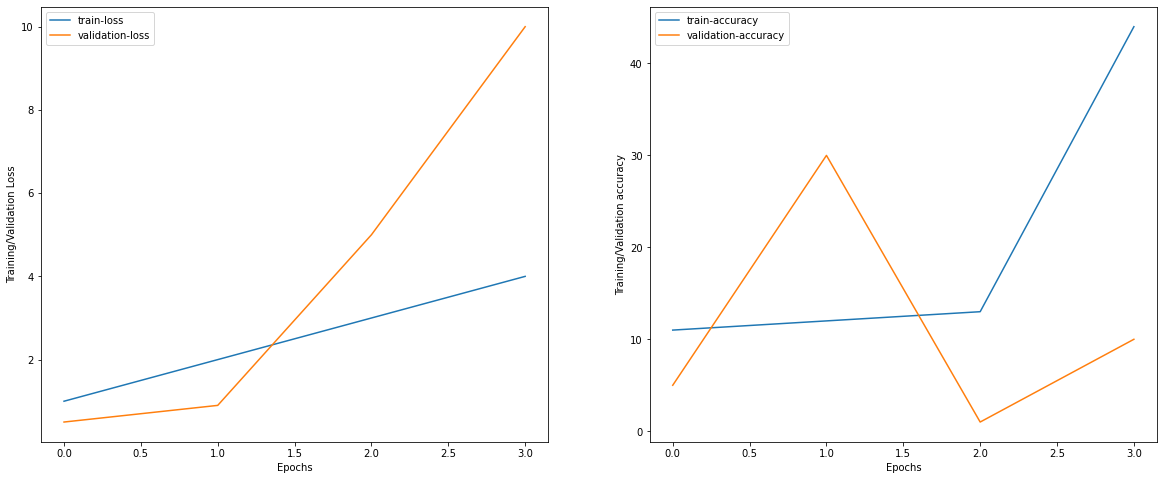

In [30]:
epochs = 3

training_loss_history = [1,2,3,4]
validation_loss_history = [0.5, 0.9, 5, 10]

training_accuracy_history = [11,12,13,44]
validation_accuracy_history = [5, 30, 1, 10]

fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(1, 2, 1)
plt.plot(range(epochs+1), training_loss_history, label='train-loss')
plt.plot(range(epochs+1), validation_loss_history, label= 'validation-loss')
plt.ylabel('Training/Validation Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
# plt.savefig(f"/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/{current_time}_loss-plot.jpg")

ax = fig.add_subplot(1, 2, 2)
plt.plot(range(epochs+1), training_accuracy_history, label='train-accuracy')
plt.plot(range(epochs+1), validation_accuracy_history, label= 'validation-accuracy')
plt.ylabel('Training/Validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc='best')
# plt.savefig(f"/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/{current_time}_accuracy-plot.jpg")

fig.savefig(f"/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/test_loss_accuracy-plot.jpg")

In [1]:
import torch
import torch.nn as nn
from torchvision import models

class Model():
    """class to hold model objects"""
    def __init__(self, model_name='vgg16'):
        """
        Keyword Argumens: 
            model_name : str, optional (default is 'vgg16')
                placeholder for future testing of multiple architectures
                for fine-tuining 
        """

        self.model_name = model_name

        if model_name == 'vgg16':

            #collect the VGG16 model architecture and weights (trained on
            #the 14million-strong ImageNet dataset) from Pytorch's Model Zoo
            #source: https://pytorch.org/vision/stable/models.html
            #paper: https://arxiv.org/abs/1409.1556
            self.model = models.vgg16(pretrained=True)

    def construct_model(self, verbose=False):
        """
        function to replace the last fully connected
        layer of the model (1000 nodes for the
        1000 classes of ImageNet) with the custom layer
        we need to solve our problem

        Note: no activation function on the final linear
        layer since we will be using nn.CrossEntropyLoss() 
        as our loss function an that depends upon the raw
        score of the nodes being output at the end of the 
        forward pass

        Keyword Argumens: 
            verbose : bool, optional (default is False)
                control the amount of output when building
                i.e. weather to print the model
        """

        #go through the feature extraction portion of the
        #model and ensure that they will not experience weight
        #updates during training
        for param in self.model.features.parameters():
            param.requires_grad = False
            if verbose: print("features param: ", param)

        #collect the number of nodes to connect to in the
        #second to last linear layer (vgg16 it's layer 6)
        input_features = self.model.classifier[6].in_features

        #construct our custom classification layer
        terminal_layer = nn.Linear(input_features, 2)

        #replace the original final linear layer with ours
        self.model.classifier[6] = terminal_layer
        
        #set params to true? (shouldn't this already be done?)
        for param in self.model.classifier.parameters():
            param.requires_grad = True
            if verbose: print("classifier param: ", param)

        #check for verbosity
        if verbose: print(self.model)

        return self.model

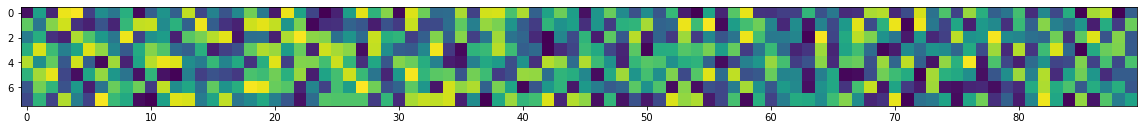

In [47]:
# from matplotlib import pyplot as plt
import random
import numpy as np

random = np.random.random ([8,90])

plt.figure(figsize = (20,2))
plt.imshow(random, interpolation='nearest')